In [21]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import pickle

In [ ]:
mean_squared_error()

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/20 19:40:43 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747770043205, experiment_id='1', last_update_time=1747770043205, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [4]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
df.shape

(76518, 20)

In [6]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [7]:
df['duration'] = df.duration.dt.total_seconds() / 60

/tmp/ipykernel_12154/3411919821.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration']);


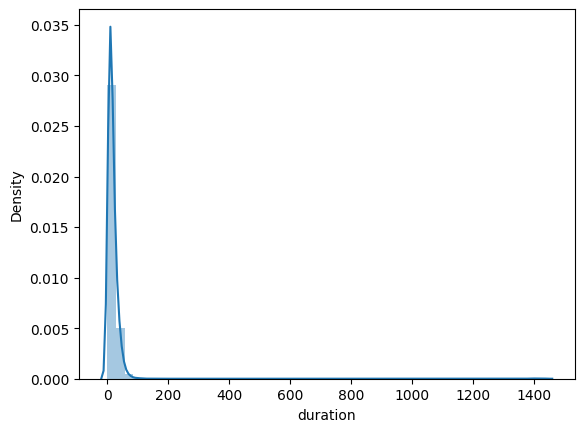

In [8]:
sns.distplot(df['duration']);

In [9]:
df['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [11]:
categorical = ['PULocationID', 'DOLocationID']

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
train_dicts = df[categorical].to_dict(orient='records')

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
target = 'duration'
y_train = df[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [23]:
print(f'Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Train RMSE: 9.775596030330492


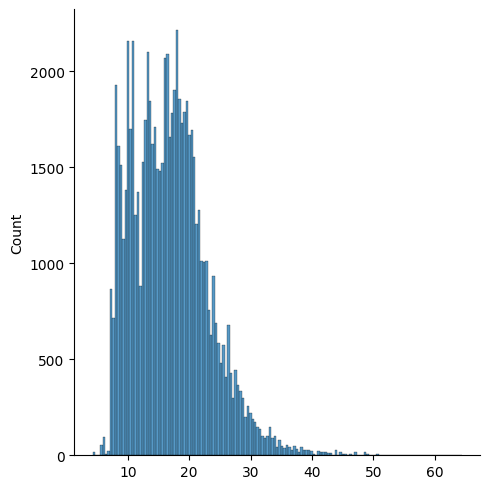

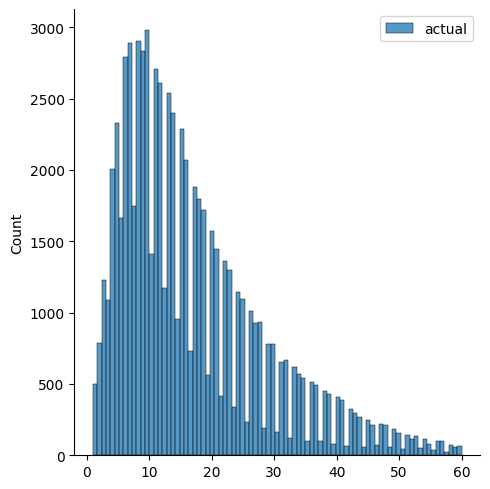

In [24]:
sns.displot(y_pred, label='prediction');
sns.displot(y_train, label='actual');

plt.legend();

In [25]:
y_pred

array([ 7.1795508 , 13.5826054 ,  8.5030211 , ..., 14.09772184,
       16.82464724, 19.46755527])

In [26]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [27]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [28]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [29]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [30]:
y_pred = lr.predict(X_val)
print(f'Val RMSE: {root_mean_squared_error(y_val, y_pred)}')

Val RMSE: 10.473740383612524


In [33]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [34]:
with mlflow.start_run():
    mlflow.set_tag("developer","avt")
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)